<a href="https://colab.research.google.com/github/adelante4/CS-SBU-NeuralNetwork_MSc2021-projects/blob/main/AdelMostafavi-99422178/Project3/NN_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
from torchvision import models
import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
from torchvision.utils import save_image
import PIL
import os
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data
import torch.optim as optim
from skimage import io, transform
from skimage.color import rgb2lab, lab2rgb
from skimage.util import random_noise

# RGB Images

## Data Preprocessing

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"adelante4","key":"0b263b5da115f40b8625fafbce0b2797"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

art-images-drawings-painting-sculpture-engraving.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('art-images-drawings-painting-sculpture-engraving.zip', 'r')
zip_ref.extractall('files')

### Removing Corrupt Files

In [ ]:
dirs = ['/content/files/dataset/dataset_updated/training_set/painting/', '/content/files/dataset/dataset_updated/training_set/drawings/', 
        '/content/files/dataset/dataset_updated/training_set/iconography/', '/content/files/dataset/dataset_updated/validation_set/painting/', '/content/files/dataset/dataset_updated/validation_set/drawings/', 
        '/content/files/dataset/dataset_updated/validation_set/iconography/']
corrupted = []
for dir in dirs:
  images = glob.glob(dir+'*')
  for single_image_path in images:
    try:
      Image.open(single_image_path)
    except:
      corrupted.append(single_image_path)      



In [ ]:
for c in corrupted:
  os.remove(c)

### Dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, roots, validation=False, transform=None):
        self.roots = roots
        self.image_list=[]
        self.validation = validation
        for root in roots:
          self.image_list += glob.glob(root+'*')
        self.transform = transform

    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        image = Image.open(single_image_path).convert('RGB')
        image = np.asarray(image) / 255

        image = np.moveaxis(image, -1, 0)
        if self.transform:
            image = self.transform(torch.from_numpy(image).float())

        gray = torchvision.transforms.Grayscale(num_output_channels=1)(image)

        return gray, image

    def __len__(self):
        return len(self.image_list)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)), 
])

train_dataset = MyDataset(['/content/files/dataset/dataset_updated/training_set/painting/', '/content/files/dataset/dataset_updated/training_set/drawings/', 
                     '/content/files/dataset/dataset_updated/training_set/iconography/'], transform=transforms)
test_dataset = MyDataset(['/content/files/dataset/dataset_updated/validation_set/painting/', '/content/files/dataset/dataset_updated/validation_set/drawings/', 
                     '/content/files/dataset/dataset_updated/validation_set/iconography/'], transform=transforms)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

### Visualizing Some Samples

In [ ]:
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


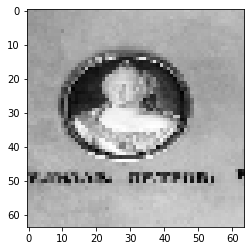

In [ ]:
plt.imshow(test_dataset[0][0][0,:,:], cmap='gray')

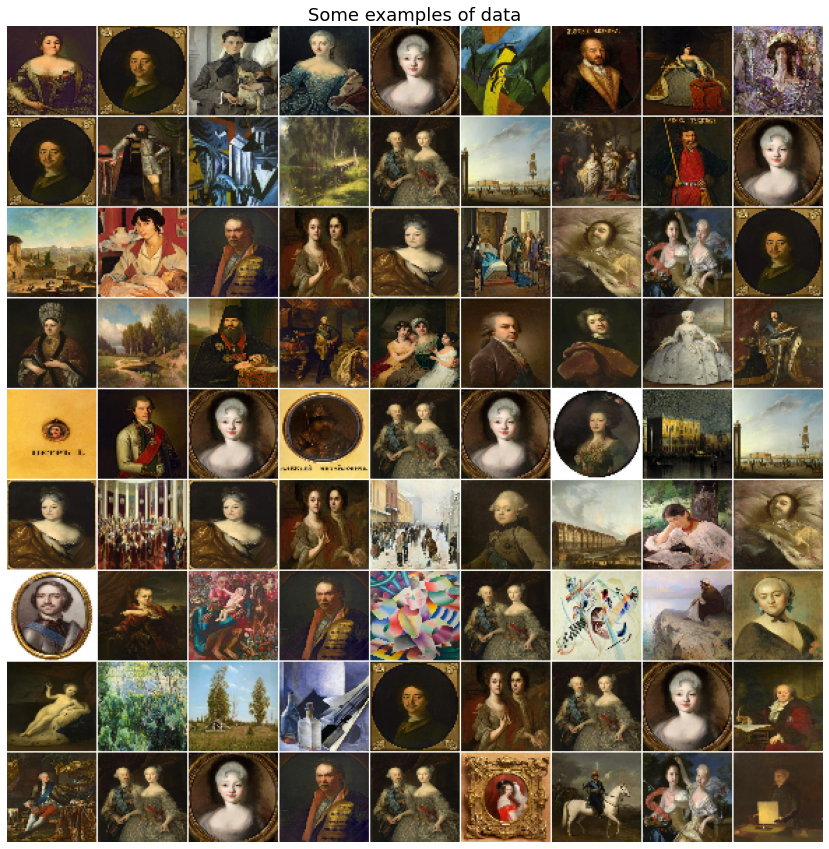

In [ ]:
samples = []
for i in range(81):
    samples.append(np.array(train_dataset[i][1]))
fig = plt.figure()
grid = convert_to_grid(np.array(samples).transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of data', fontsize=18)

# Showing the plot
plt.show()

## Model Architectures 

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4, self).__init__()

        self.relu = nn.ReLU()
        
        self.final = nn.Sigmoid()        
        self.upsampling = nn.Upsample(scale_factor=2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1, bias=True)
        
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv8 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3,3), stride=1, padding=1, bias=True)

        self.color = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.upsampling,
            self.conv7,
            self.relu,
            self.upsampling,
            self.conv8,
            self.relu,
            self.upsampling,
            self.conv9,
            self.final
        )
    
    def forward(self, x):
        return self.color(x)

### Training

In [ ]:
def train(model, train_loader, criterion, num_epochs=5, batch_size=64, learning_rate=.001, schedule_lr=False):
    # optimizer = torch.optim.AdamW(model.parameters(),
    #                              lr=learning_rate, 
    #                              )

    # optimizer = torch.optim.SGD(model.parameters(),
    #                              lr=learning_rate, 
    #                              momentum=0.9)

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 amsgrad=True)
    
    if schedule_lr:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

        
    training_losses = []
    for epoch in range(num_epochs):
        training_loss = 0
        for data in train_loader:
            gray, colored = data
            if torch.cuda.is_available():
              gray = gray.cuda()
              colored = colored.cuda()
            painted = model(gray)
            # print(painted.shape)
            loss = criterion(colored, painted)
            if schedule_lr:
                scheduler.step(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            training_loss += loss

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        training_losses.append(training_loss)
    return training_losses

In [ ]:
model4 = Autoencoder4()
criterion = nn.MSELoss() 

if torch.cuda.is_available():
    print('cuda available')
    model4 = model4.cuda()
max_epochs = 50
history4 = train(model4, train_loader, criterion, num_epochs=max_epochs, learning_rate=.0001)

cuda available
Epoch:1, Loss:0.0869
Epoch:2, Loss:0.0732
Epoch:3, Loss:0.0668
Epoch:4, Loss:0.0487
Epoch:5, Loss:0.0492
Epoch:6, Loss:0.0393
Epoch:7, Loss:0.0285
Epoch:8, Loss:0.0288
Epoch:9, Loss:0.0215
Epoch:10, Loss:0.0227
Epoch:11, Loss:0.0196
Epoch:12, Loss:0.0207
Epoch:13, Loss:0.0233
Epoch:14, Loss:0.0210
Epoch:15, Loss:0.0195
Epoch:16, Loss:0.0216
Epoch:17, Loss:0.0203
Epoch:18, Loss:0.0195
Epoch:19, Loss:0.0186
Epoch:20, Loss:0.0221
Epoch:21, Loss:0.0187
Epoch:22, Loss:0.0194
Epoch:23, Loss:0.0196
Epoch:24, Loss:0.0192
Epoch:25, Loss:0.0169
Epoch:26, Loss:0.0192
Epoch:27, Loss:0.0172
Epoch:28, Loss:0.0187
Epoch:29, Loss:0.0179
Epoch:30, Loss:0.0164
Epoch:31, Loss:0.0204
Epoch:32, Loss:0.0173
Epoch:33, Loss:0.0165
Epoch:34, Loss:0.0182
Epoch:35, Loss:0.0193
Epoch:36, Loss:0.0176
Epoch:37, Loss:0.0157
Epoch:38, Loss:0.0173
Epoch:39, Loss:0.0163
Epoch:40, Loss:0.0172
Epoch:41, Loss:0.0151
Epoch:42, Loss:0.0166
Epoch:43, Loss:0.0178
Epoch:44, Loss:0.0176
Epoch:45, Loss:0.0171
Epoc

In [ ]:
model3 = Autoencoder2()
criterion = nn.MSELoss() 

if torch.cuda.is_available():
    print('cuda available')
    model3 = model3.cuda()
max_epochs = 25
history3 = train(model3, train_loader, criterion, num_epochs=max_epochs)

cuda available
Epoch:1, Loss:0.0435
Epoch:2, Loss:0.0383
Epoch:3, Loss:0.0287
Epoch:4, Loss:0.0282
Epoch:5, Loss:0.0257
Epoch:6, Loss:0.0236
Epoch:7, Loss:0.0202
Epoch:8, Loss:0.0204
Epoch:9, Loss:0.0218
Epoch:10, Loss:0.0204
Epoch:11, Loss:0.0217
Epoch:12, Loss:0.0174
Epoch:13, Loss:0.0183
Epoch:14, Loss:0.0200
Epoch:15, Loss:0.0208
Epoch:16, Loss:0.0209
Epoch:17, Loss:0.0169
Epoch:18, Loss:0.0188
Epoch:19, Loss:0.0191
Epoch:20, Loss:0.0188
Epoch:21, Loss:0.0179
Epoch:22, Loss:0.0172
Epoch:23, Loss:0.0164
Epoch:24, Loss:0.0185
Epoch:25, Loss:0.0172


In [ ]:
# model2 = Autoencoder2()
# criterion = nn.MSELoss() 

# if torch.cuda.is_available():
#     print('cuda available')
#     model2 = model2.cuda()
# max_epochs = 50
# history2 = train(model2, train_loader, criterion, num_epochs=max_epochs)

In [ ]:
# model = Autoencoder()
# criterion = nn.MSELoss() 

# if torch.cuda.is_available():
#     print('cuda available')
#     model = model.cuda()
# max_epochs = 50
# history = train(model, train_loader, criterion, num_epochs=max_epochs)

### Results

In [ ]:
def show_results(model, history, index):
  plt.plot(range(1,len(history)+1,1), history)
  plt.xlabel('epoch')
  plt.ylabel('MSE loss')
  preds = []
  with torch.no_grad():
      for gray, colored in test_loader:

          if torch.cuda.is_available():
              gray = gray.cuda()

          output = model(gray).cpu()
          for c, o in zip(colored, output):
              preds.append([o, c])
  for i in index:            
      original = preds[i][1].permute(1,2,0)
      pred = preds[i][0].permute(1,2,0)
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.set_title("original image")
      ax1.imshow(original)

      ax2.set_title("colored by model")
      ax2.imshow(pred)

      plt.show()

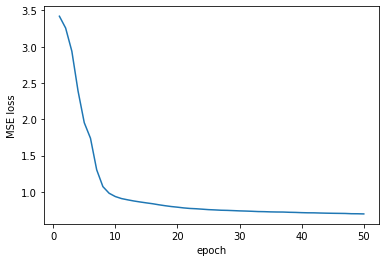

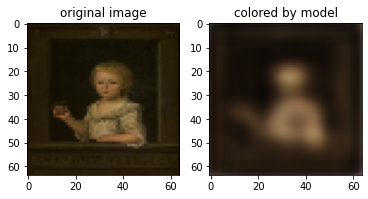

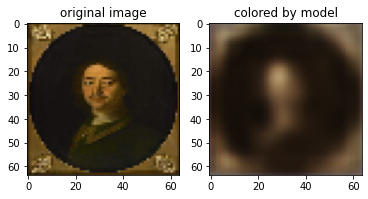

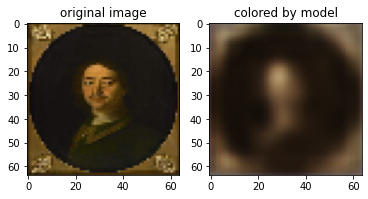

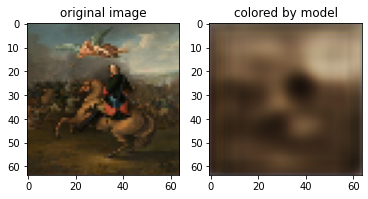

In [ ]:
show_results(model4, history4, [10, 100, 40, 44])

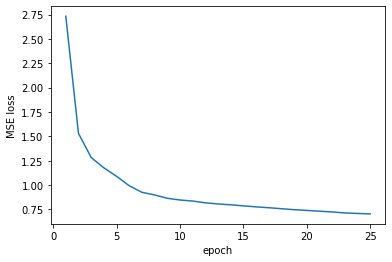

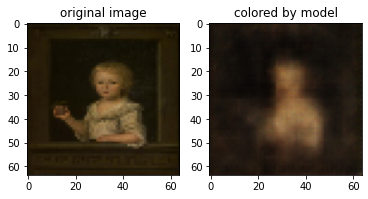

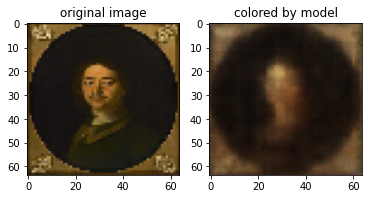

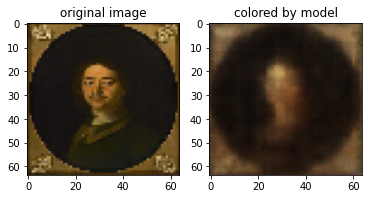

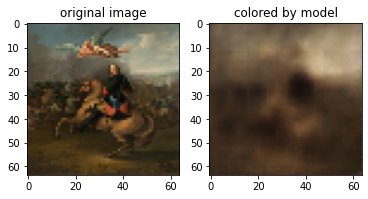

In [ ]:
show_results(model3, history3, [10, 100, 40, 44])

In [ ]:
# show_results(model2, history2, [10, 100, 40, 44])

In [ ]:
# show_results(model, history, [10, 100, 40, 44])

# LAB Images

## Data Preprocessing

### Dataset

In [ ]:
class MyLabDataset(Dataset):
    def __init__(self, roots, validation=False, transform=None):
        self.roots = roots
        self.image_list=[]
        self.validation = validation
        for root in roots:
          self.image_list += glob.glob(root+'*')
        self.transform = transform

    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        image = Image.open(single_image_path).convert('RGB')
        image = np.asarray(image) / 255

        image = np.moveaxis(image, -1, 0)


        if self.transform:
            image = self.transform(torch.from_numpy(image).float())

        img_lab = rgb2lab(image.permute((1, 2, 0)))
        img_lab = (img_lab) / [100, 128, 128] 

        img_ab = img_lab[:,:,1:3]
        img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
        
        img_gray = img_lab[:,:,0]
        img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()

        
        return img_gray, img_ab

    def __len__(self):
        return len(self.image_list)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)), 
])

train_dataset = MyLabDataset(['/content/files/dataset/dataset_updated/training_set/painting/', 
                     '/content/files/dataset/dataset_updated/training_set/iconography/'], transform=transforms)
test_dataset = MyLabDataset(['/content/files/dataset/dataset_updated/validation_set/painting/',
                     '/content/files/dataset/dataset_updated/validation_set/iconography/'], transform=transforms)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

### Visualizing Samples

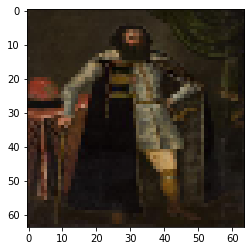

In [ ]:
cur = np.zeros((64, 64, 3))
cur[:,:,0] = train_dataset[10][0][0,:,:]*100
cur[:,:,1:] = train_dataset[10][1].permute(1,2,0)*128
cur = lab2rgb(cur)
plt.imshow(cur)

## Model Architectures

In [ ]:
class ResnetAE(nn.Module):
  def __init__(self, input_size=128):
    super(ResnetAE, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    resnet = models.resnet18(num_classes=365) 

    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 

    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2),
      nn.Tanh()
    )

  def forward(self, input):
    midlevel_features = self.midlevel_resnet(input)
    output = self.upsample(midlevel_features)
    return output

In [ ]:
class PretrainedAE(nn.Module):
  def __init__(self, input_size=128):
    super(PretrainedAE, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    resnet = models.resnet18(pretrained=True) 
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2),
      nn.Tanh()
    )

  def forward(self, input):
    midlevel_features = self.midlevel_resnet(input)
    output = self.upsample(midlevel_features)
    return output

In [ ]:
class Autoencoder5(nn.Module):
    def __init__(self, d=128):
        super(Autoencoder5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) 
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) 
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) 
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) 

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = F.tanh(self.tconv3(x))

        return x

### Training

In [ ]:
model5 = ResnetAE()
criterion = nn.MSELoss() 
 
if torch.cuda.is_available():
    print('cuda available')
    model5 = model5.cuda()
max_epochs = 30
history5 = train(model5, train_loader, criterion, num_epochs=max_epochs, learning_rate=.001)

cuda available
Epoch:1, Loss:0.0075
Epoch:2, Loss:0.0103
Epoch:3, Loss:0.0092
Epoch:4, Loss:0.0092
Epoch:5, Loss:0.0098
Epoch:6, Loss:0.0093
Epoch:7, Loss:0.0096
Epoch:8, Loss:0.0102
Epoch:9, Loss:0.0099
Epoch:10, Loss:0.0083
Epoch:11, Loss:0.0083
Epoch:12, Loss:0.0087
Epoch:13, Loss:0.0073
Epoch:14, Loss:0.0079
Epoch:15, Loss:0.0091
Epoch:16, Loss:0.0075
Epoch:17, Loss:0.0066
Epoch:18, Loss:0.0069
Epoch:19, Loss:0.0084
Epoch:20, Loss:0.0054
Epoch:21, Loss:0.0075
Epoch:22, Loss:0.0062
Epoch:23, Loss:0.0089
Epoch:24, Loss:0.0064
Epoch:25, Loss:0.0058
Epoch:26, Loss:0.0074
Epoch:27, Loss:0.0055
Epoch:28, Loss:0.0067
Epoch:29, Loss:0.0039
Epoch:30, Loss:0.0047


In [ ]:
model6 = PretrainedAE()
criterion = nn.MSELoss() 
 
if torch.cuda.is_available():
    print('cuda available')
    model6 = model6.cuda()
max_epochs = 30
history6 = train(model6, train_loader, criterion, num_epochs=max_epochs)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



cuda available
Epoch:1, Loss:0.0117
Epoch:2, Loss:0.0120
Epoch:3, Loss:0.0127
Epoch:4, Loss:0.0091
Epoch:5, Loss:0.0095
Epoch:6, Loss:0.0058
Epoch:7, Loss:0.0101
Epoch:8, Loss:0.0079
Epoch:9, Loss:0.0084
Epoch:10, Loss:0.0052
Epoch:11, Loss:0.0069
Epoch:12, Loss:0.0060
Epoch:13, Loss:0.0075
Epoch:14, Loss:0.0055
Epoch:15, Loss:0.0053
Epoch:16, Loss:0.0057
Epoch:17, Loss:0.0081
Epoch:18, Loss:0.0058
Epoch:19, Loss:0.0040
Epoch:20, Loss:0.0060
Epoch:21, Loss:0.0048
Epoch:22, Loss:0.0046
Epoch:23, Loss:0.0041
Epoch:24, Loss:0.0049
Epoch:25, Loss:0.0049
Epoch:26, Loss:0.0047
Epoch:27, Loss:0.0044
Epoch:28, Loss:0.0053
Epoch:29, Loss:0.0033
Epoch:30, Loss:0.0042


In [ ]:
model7 = Autoencoder5()
criterion = nn.MSELoss() 
 
if torch.cuda.is_available():
    print('cuda available')
    model7 = model7.cuda()
max_epochs = 30
history7 = train(model7, train_loader, criterion, num_epochs=max_epochs)

cuda available


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1, Loss:0.0144
Epoch:2, Loss:0.0120
Epoch:3, Loss:0.0134
Epoch:4, Loss:0.0132
Epoch:5, Loss:0.0111
Epoch:6, Loss:0.0100
Epoch:7, Loss:0.0077
Epoch:8, Loss:0.0138
Epoch:9, Loss:0.0082
Epoch:10, Loss:0.0085
Epoch:11, Loss:0.0100
Epoch:12, Loss:0.0142
Epoch:13, Loss:0.0114
Epoch:14, Loss:0.0077
Epoch:15, Loss:0.0082
Epoch:16, Loss:0.0105
Epoch:17, Loss:0.0131
Epoch:18, Loss:0.0129
Epoch:19, Loss:0.0086
Epoch:20, Loss:0.0083
Epoch:21, Loss:0.0119
Epoch:22, Loss:0.0093
Epoch:23, Loss:0.0093
Epoch:24, Loss:0.0082
Epoch:25, Loss:0.0097
Epoch:26, Loss:0.0097
Epoch:27, Loss:0.0055
Epoch:28, Loss:0.0053
Epoch:29, Loss:0.0074
Epoch:30, Loss:0.0067


### Results

In [ ]:
def show_results(model, history, index):
  plt.plot(range(1,len(history)+1,1), history)
  plt.xlabel('epoch')
  plt.ylabel('MSE loss')
  preds = []
  with torch.no_grad():
      for l, ab in test_loader:

          if torch.cuda.is_available():
              l = l.cuda()

          pred_ab = model(l).cpu()
          original = torch.cat((l.cpu(), ab), axis=1).permute(0, 2, 3, 1)
          for x, y in zip(original, pred_ab):
              preds.append([x, y])
  for i in index:            
      pred = np.zeros((64, 64, 3))
      pred[:,:,0] = preds[i][0][:,:,0]*100
      pred[:,:,1:] = preds[i][1].permute(1,2,0)*128
      pred = lab2rgb(pred)
      original = np.zeros((64, 64, 3))
      original[:,:,0] = preds[i][0][:,:,0]*100
      original[:,:,1:] = preds[i][0][:,:,1:]*128
      original = lab2rgb(original)
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.set_title("original image")
      ax1.imshow(original)

      ax2.set_title("colored by model")
      ax2.imshow(pred)

      plt.show()

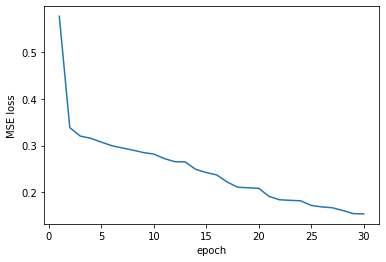

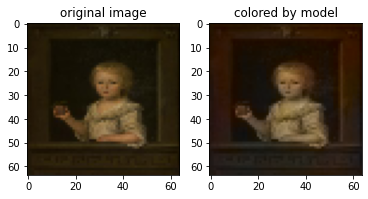

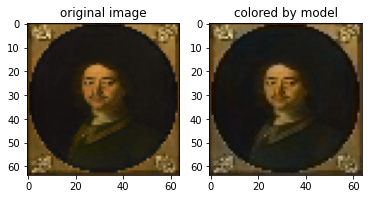

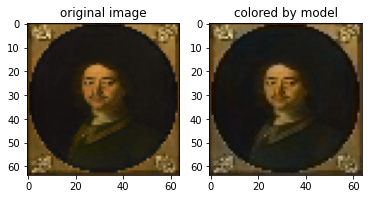

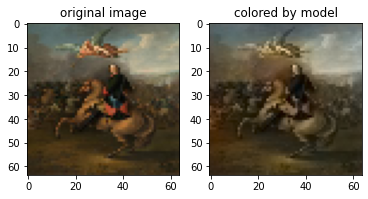

In [ ]:
show_results(model5, history5, [10, 100, 40, 44])

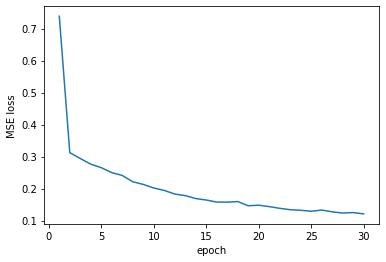

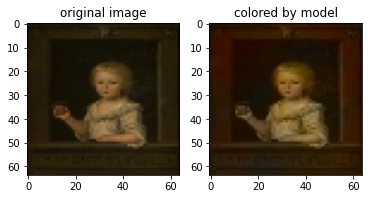

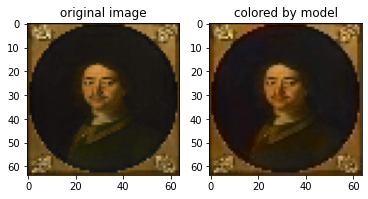

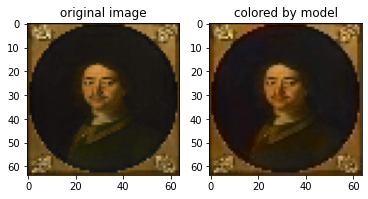

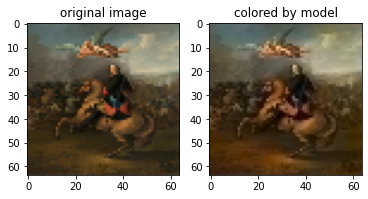

In [ ]:
show_results(model6, history6, [10, 100, 40, 44])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


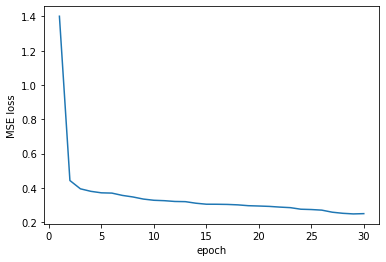

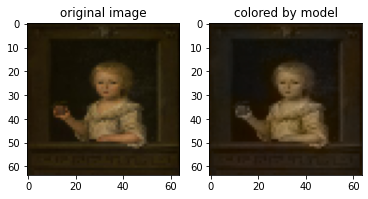

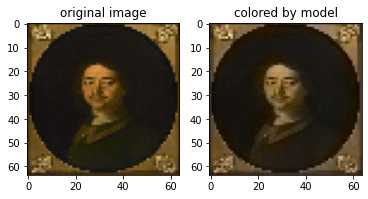

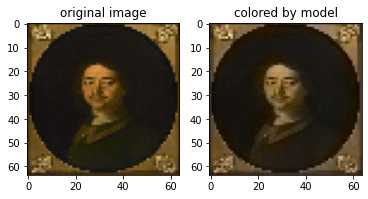

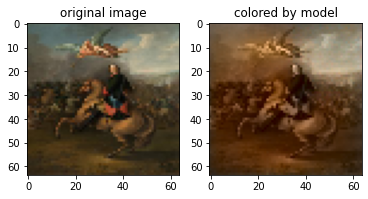

In [ ]:
show_results(model7, history7, [10, 100, 40, 44])

# Denoising photos

## Noisy dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, roots, validation=False, transform=None):
        self.roots = roots
        self.image_list=[]
        self.validation = validation
        for root in roots:
          self.image_list += glob.glob(root+'*')
        self.transform = transform

    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        image = Image.open(single_image_path).convert('RGB')
        image = np.asarray(image) / 255

        image = np.moveaxis(image, -1, 0)
        if self.transform:
            image = self.transform(torch.from_numpy(image).float())

        noised = torch.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))


        return noised, image

    def __len__(self):
        return len(self.image_list)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)), 
])

train_dataset = MyDataset(['/content/files/dataset/dataset_updated/training_set/painting/', '/content/files/dataset/dataset_updated/training_set/drawings/', 
                     '/content/files/dataset/dataset_updated/training_set/iconography/'], transform=transforms)
test_dataset = MyDataset(['/content/files/dataset/dataset_updated/validation_set/painting/', '/content/files/dataset/dataset_updated/validation_set/drawings/', 
                     '/content/files/dataset/dataset_updated/validation_set/iconography/'], transform=transforms)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

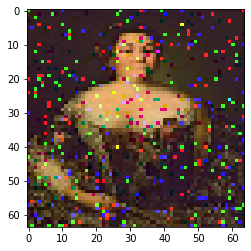

In [ ]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

## Model Architecture

In [ ]:
resnet = models.resnet18(num_classes=365) 
list(resnet.children())[0:9]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
class ResnetAE(nn.Module):
  def __init__(self, input_size=128):
    super(ResnetAE, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    resnet = models.resnet18(num_classes=365) 
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2),
      nn.Tanh()
    )

  def forward(self, input):
    midlevel_features = self.midlevel_resnet(input)
    output = self.upsample(midlevel_features)
    return output

### Training

In [ ]:
model8 = ResnetAE()
criterion = nn.MSELoss() 
 
if torch.cuda.is_available():
    print('cuda available')
    model8 = model8.cuda()
max_epochs = 30
history8 = train(model8, train_loader, criterion, num_epochs=max_epochs, learning_rate=.0001)

cuda available
Epoch:1, Loss:0.0573
Epoch:2, Loss:0.0350
Epoch:3, Loss:0.0291
Epoch:4, Loss:0.0268
Epoch:5, Loss:0.0169
Epoch:6, Loss:0.0210
Epoch:7, Loss:0.0194
Epoch:8, Loss:0.0186
Epoch:9, Loss:0.0171
Epoch:10, Loss:0.0162
Epoch:11, Loss:0.0194
Epoch:12, Loss:0.0143
Epoch:13, Loss:0.0167
Epoch:14, Loss:0.0154
Epoch:15, Loss:0.0167
Epoch:16, Loss:0.0162
Epoch:17, Loss:0.0166
Epoch:18, Loss:0.0152
Epoch:19, Loss:0.0166
Epoch:20, Loss:0.0151
Epoch:21, Loss:0.0145
Epoch:22, Loss:0.0145
Epoch:23, Loss:0.0146
Epoch:24, Loss:0.0152
Epoch:25, Loss:0.0170
Epoch:26, Loss:0.0148
Epoch:27, Loss:0.0150
Epoch:28, Loss:0.0144
Epoch:29, Loss:0.0143
Epoch:30, Loss:0.0142


### Results

In [ ]:
def show_results(model, history, index):
  plt.plot(range(1,len(history)+1,1), history)
  plt.xlabel('epoch')
  plt.ylabel('MSE loss')
  preds = []
  with torch.no_grad():
      for noisy, normal in test_loader:

          if torch.cuda.is_available():
              noisy = noisy.cuda()

          output = model(noisy).cpu()
          for n, o in zip(noisy.cpu(), output):
              preds.append([o, n])
  for i in index:            
      original = preds[i][1].permute(1,2,0)
      pred = preds[i][0].permute(1,2,0)
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.set_title("noisy image")
      ax1.imshow(original)

      ax2.set_title("denoised by model")
      ax2.imshow(pred)

      plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


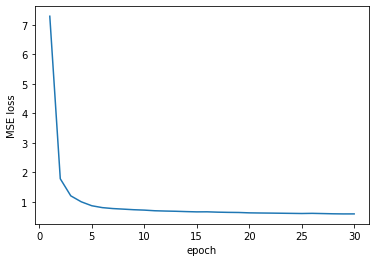

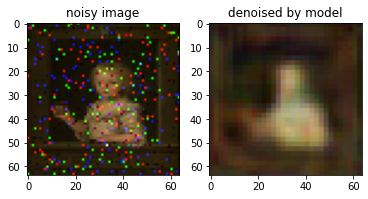

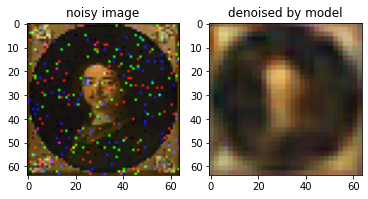

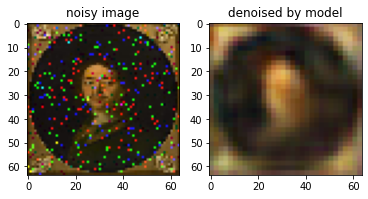

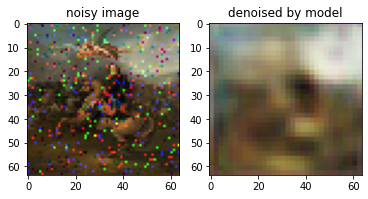

In [ ]:
show_results(model8, history8, [10, 100, 40, 44])

# Variational AutoEncoder Fruit Generation!

## Data Preprocessing

In [ ]:
!kaggle datasets download -d moltean/fruits

 98% 741M/760M [00:04<00:00, 208MB/s]
100% 760M/760M [00:04<00:00, 166MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('fruits.zip', 'r')
zip_ref.extractall('files')

In [ ]:
batch_size=128

train_dataset = torchvision.datasets.ImageFolder('/content/files/fruits-360/Training', transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder('/content/files/fruits-360/Test', transform=torchvision.transforms.ToTensor())

train_loader_food = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size, shuffle=True)

val_loader_food = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size, shuffle=True)


## Model Architecture

In [ ]:
class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25 * 25 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [ ]:
model = VAE_CNN().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()

In [ ]:
val_losses = []
train_losses = []
log_interval = 50


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_food):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_food.dataset),
                       100. * batch_idx / len(train_loader_food),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader_food.dataset)))
    train_losses.append(train_loss / len(train_loader_food.dataset))

In [ ]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader_food):
            data = data.cuda()
            recon_batch, mu, logvar = model(data)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()
            # if i == 0:
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([data[:n],
            #                             recon_batch.view(batch_size, 3, 100, 100)[:n]])
            #     save_image(comparison.cpu(),
            #                '../results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(val_loader_food.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

### Training

In [ ]:
epochs = 10

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2048).cuda()
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 3, 100, 100),
                   'sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/67692 (0%)]	Loss: 38196.625000
Train Epoch: 1 [6400/67692 (9%)]	Loss: 1861.977417
Train Epoch: 1 [12800/67692 (19%)]	Loss: 1138.328125
Train Epoch: 1 [19200/67692 (28%)]	Loss: 905.881287
Train Epoch: 1 [25600/67692 (38%)]	Loss: 791.223389
Train Epoch: 1 [32000/67692 (47%)]	Loss: 801.730286
Train Epoch: 1 [38400/67692 (57%)]	Loss: 688.047974
Train Epoch: 1 [44800/67692 (66%)]	Loss: 631.330505
Train Epoch: 1 [51200/67692 (76%)]	Loss: 622.138062
Train Epoch: 1 [57600/67692 (85%)]	Loss: 593.866760
Train Epoch: 1 [64000/67692 (95%)]	Loss: 594.194946
====> Epoch: 1 Average loss: 1385.1362
====> Test set loss: 529.7632
Train Epoch: 2 [0/67692 (0%)]	Loss: 556.496216
Train Epoch: 2 [6400/67692 (9%)]	Loss: 553.169250
Train Epoch: 2 [12800/67692 (19%)]	Loss: 563.230347
Train Epoch: 2 [19200/67692 (28%)]	Loss: 515.079041
Train Epoch: 2 [25600/67692 (38%)]	Loss: 473.994751
Train Epoch: 2 [32000/67692 (47%)]	Loss: 484.635468
Train Epoch: 2 [38400/67692 (57%)]	Loss: 519.987854
Train

## Creating new fruits
by combining two fruits

In [ ]:
x1 = train_dataset[5000][0] 
x2 = train_dataset[8000][0]
x = torch.stack([x1,x2])     
mu, logvar = model.encode(x.cuda())
embedding = model.reparameterize(mu, logvar)
e1 = embedding[0] 
e2 = embedding[1]

In [ ]:
embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decode(embedding_values).cpu()

In [ ]:
recons.shape

torch.Size([10, 3, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

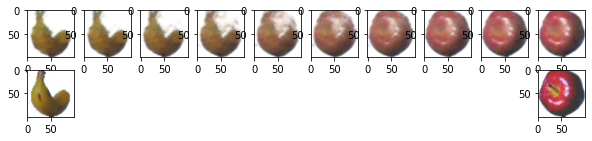

In [ ]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon.transpose(1, 2, 0))
plt.subplot(2,10,11)
plt.imshow(x2.permute(1, 2, 0))
plt.subplot(2,10,20)
plt.imshow(x1.permute(1, 2, 0))